In [1]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle

In [2]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [3]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [4]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield["date"] = market_yield["date"].shift(-5)
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy["date"] = spy["date"].shift(-5)
spy = processor.column_date_processing(spy)
fred.disconnect()

In [5]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
        price = price.dropna()
        price["historical_return"] = price["adjclose"].pct_change(5)
        price["cov"] = price["spy"].rolling(100).cov(price["historical_return"])
        price["var"] = price["spy"].rolling(100).var()
        price["beta"] = price["cov"] / price["var"]
        price["prediction"] = price["rf"] + price["beta"] * (price["historical_return"] - price["rf"])
        price["sigma"] = price["adjclose"].pct_change(65)
        price["excess_return"] = price["prediction"] 
        prices.append(price.dropna())
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:05<00:00, 89.56it/s]


In [6]:
sim = pd.concat(prices)[["date","ticker","adjclose","GICS Sector","excess_return","rf","sigma"]]
sim = sim[sim["date"]>datetime(2024,1,1)].dropna()

In [7]:
# Initialize variables
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
            "bonds": [{} for _ in range(number_of_stocks)],
            "options": [{} for _ in range(number_of_stocks)]
        }
        for _ in sp500["GICS Sector"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000

for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                bonds = copy.deepcopy(position["bonds"])
                options = copy.deepcopy(position["options"])
                
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    option = options[j]
                    bond = bonds[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                        option = Option.update(row, option)
                        position["options"][j] = option
                        bond = Bond.update(row, bond)
                        position["bonds"][j] = bond
                positions[i] = position
            portfolio["positions"] = positions
            
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                bonds = copy.deepcopy(position["bonds"])
                options = copy.deepcopy(position["options"])
                
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    option = options[j]
                    bond = bonds[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        expected_return = stock["excess_return"]
                        notional = stock["pv"] + option["pv"] + bond["pv"]
                        opportunity_row = today[today["GICS Sector"] == sector].sort_values("excess_return", ascending=False).iloc[j]
                        opportunity_cost = opportunity_row["excess_return"]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (opportunity_ticker != ticker):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            option = Option.sell(row, option)
                            position["options"][j] = option
                            bond = Bond.sell(row, bond)
                            position["bonds"][j] = bond
                            stock = Stock.buy(opportunity_row, stock, notional * 1)
                            position["stocks"][j] = stock
                            option = Option.buy(opportunity_row, option, notional * 0)
                            position["options"][j] = option
                            bond = Bond.buy(opportunity_row, bond, notional * 0)
                            position["bonds"][j] = bond
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                for i in range(11):
                    notional = float(cash / 11 / number_of_stocks)
                    position = positions[i]
                    sector = list(sp500["GICS Sector"].unique())[i]
                    bonds = copy.deepcopy(position["bonds"])
                    options = copy.deepcopy(position["options"])
                    stocks = copy.deepcopy(position["stocks"])
                    
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        option = options[j]
                        bond = bonds[j]
                        row = today[today["GICS Sector"] == sector].sort_values("excess_return", ascending=False).iloc[j]
                        stock = Stock.buy(row, stock, notional * 1)
                        position["stocks"][j] = stock
                        option = Option.buy(row, option, notional * 0)
                        position["options"][j] = option
                        bond = Bond.buy(row, bond, notional * 0)
                        position["bonds"][j] = bond
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

In [8]:
portfolios = []
for state in states:
    for i in range(11):
        for j in range(number_of_stocks):
            view = state["positions"][i]["stocks"][j]
            view["date"] = state["date"]
            portfolios.append(state["positions"][i]["stocks"][j])

In [9]:
industry_visualization = pd.DataFrame(portfolios).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left").dropna().merge(market_yield[["date","rf"]],on="date",how="left")
industry_visualization = industry_visualization.groupby(["date","GICS Sector"]).agg({"pv":"sum","rf":"mean"}).reset_index()

In [10]:
industry_visualization

,date,GICS Sector,pv,rf
0,2024-01-02,Communication Services,9090.909091,0.0390
1,2024-01-02,Consumer Discretionary,9090.909091,0.0390
2,2024-01-02,Consumer Staples,9090.909091,0.0390
3,2024-01-02,Energy,9090.909091,0.0390
4,2024-01-02,Financials,9090.909091,0.0390
...,...,...,...,...
1447,2024-07-11,Industrials,8281.776133,0.0436
1448,2024-07-11,Information Technology,28646.894742,0.0436
1449,2024-07-11,Materials,7104.927339,0.0436
1450,2024-07-11,Real Estate,8289.890951,0.0436


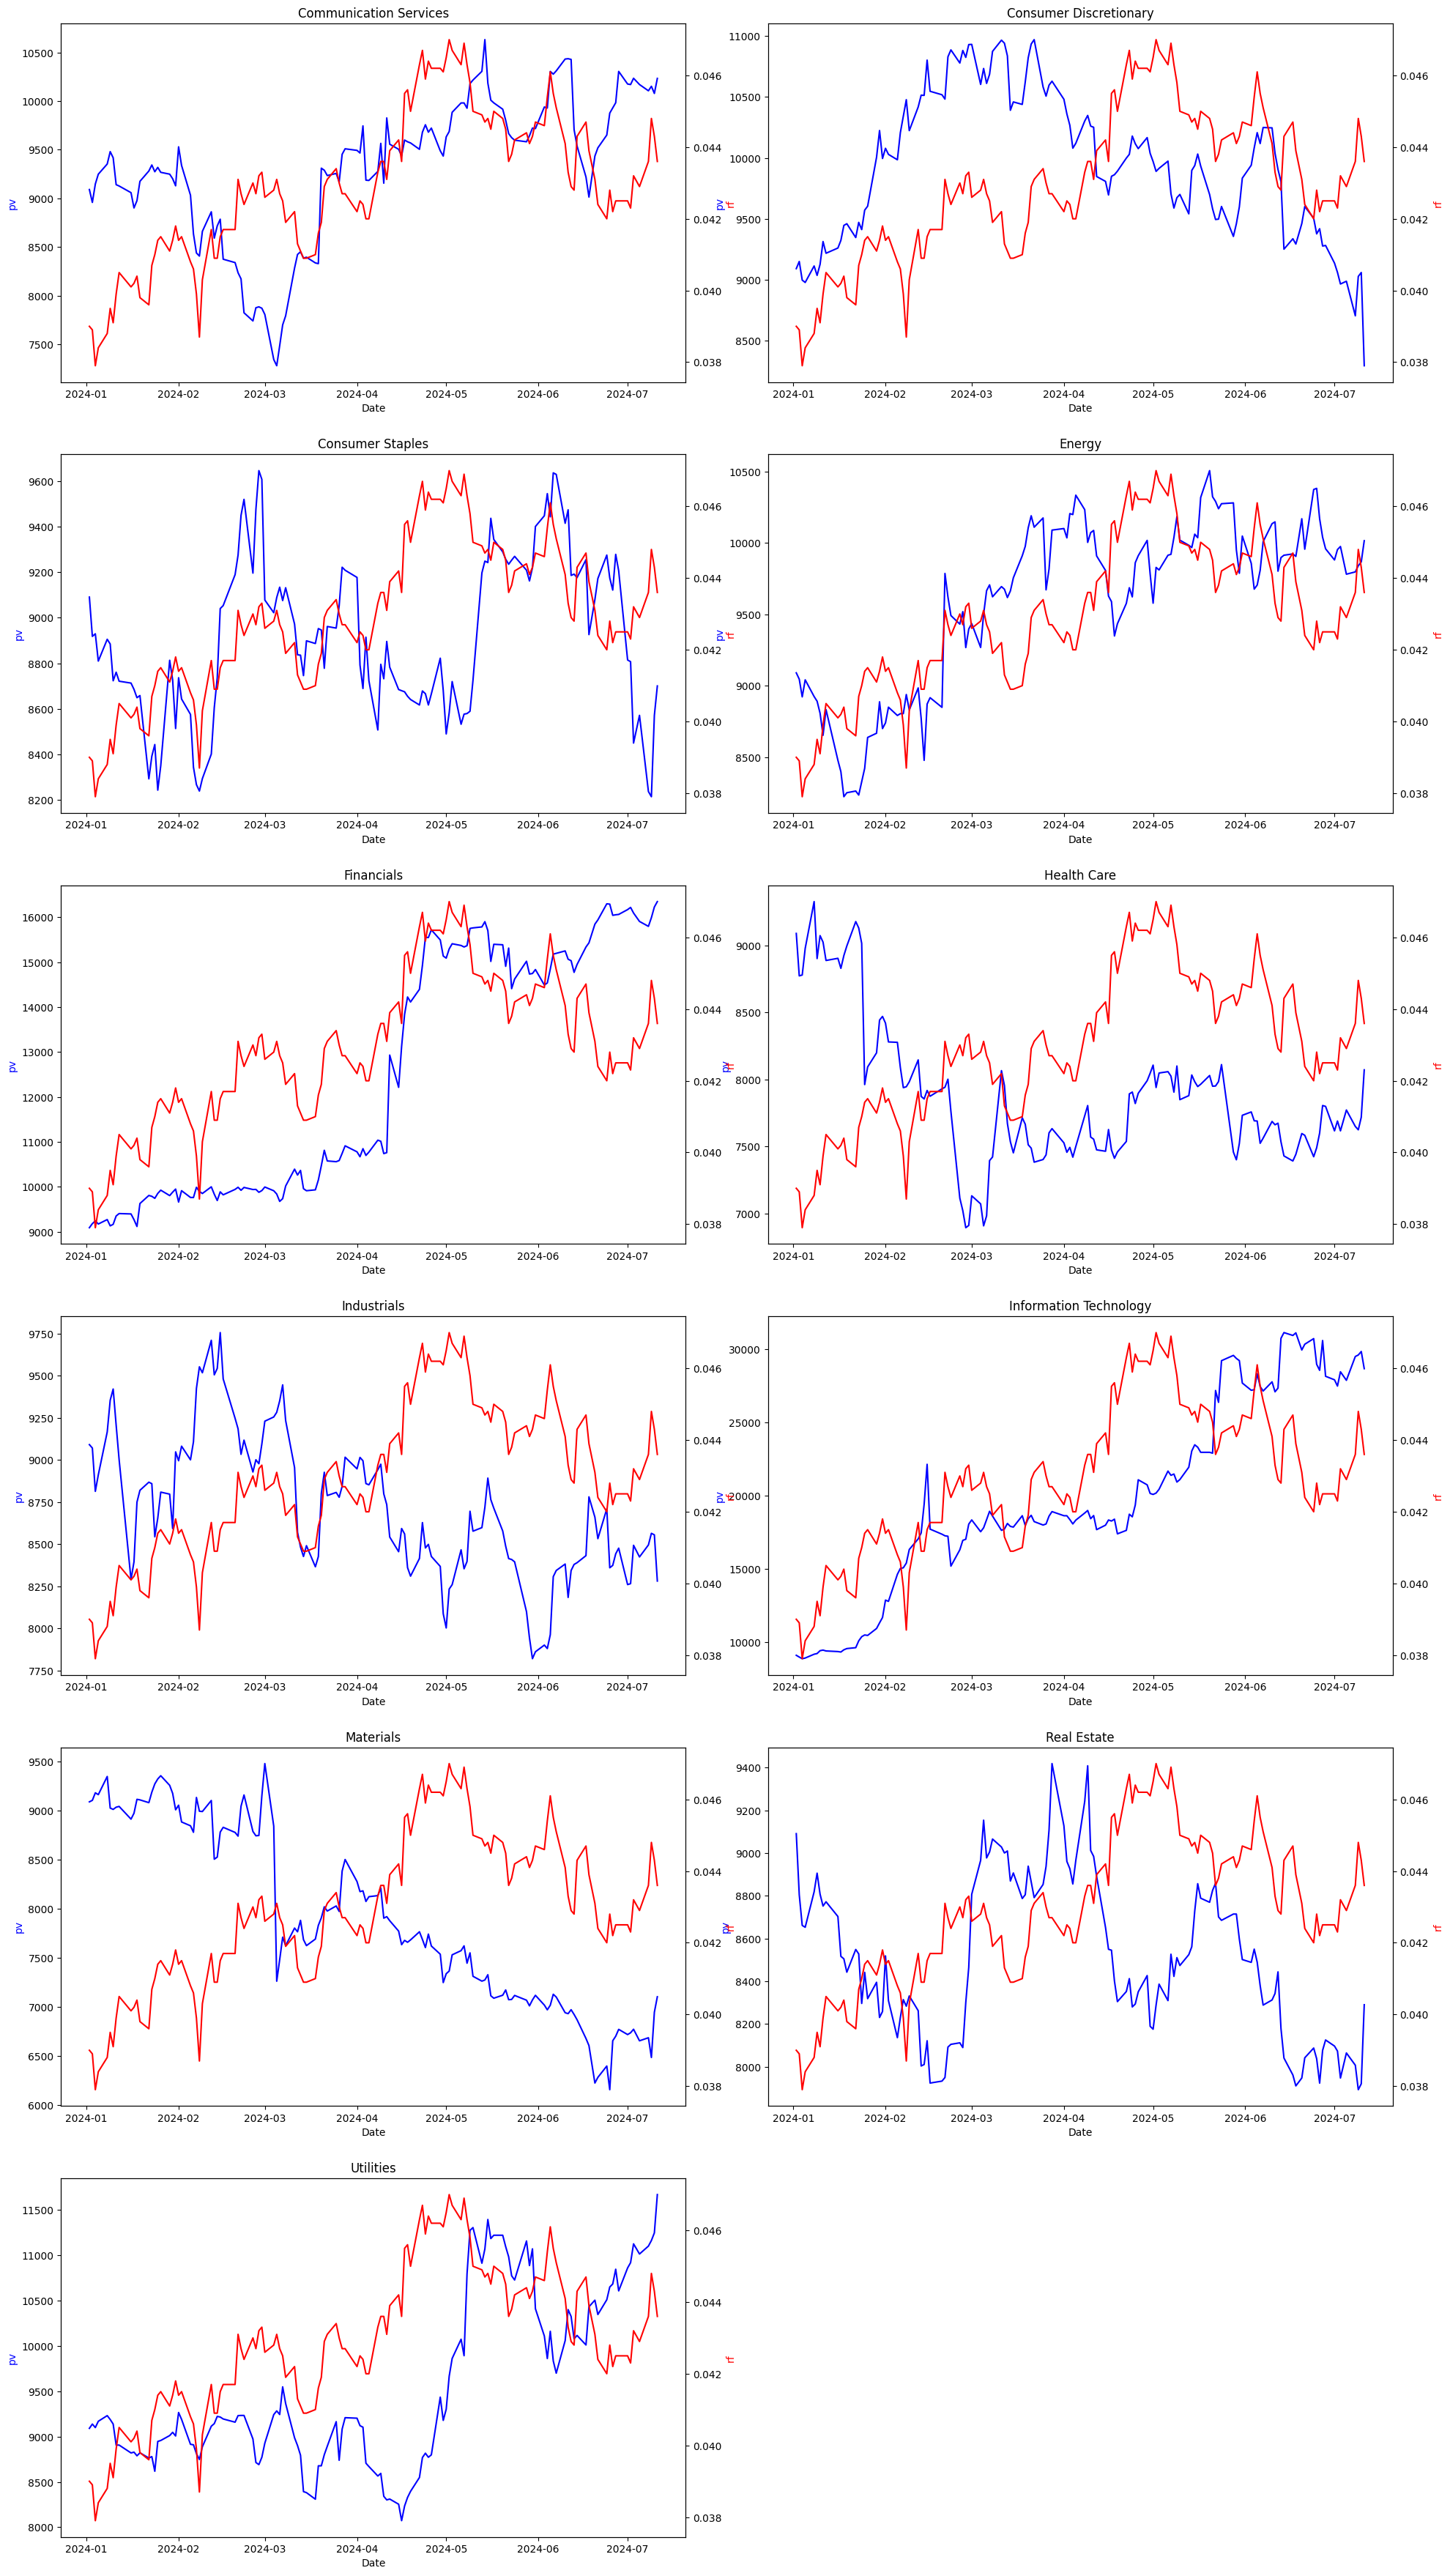

In [11]:
import matplotlib.pyplot as plt
import math

# Number of sectors
num_sectors = len(industry_visualization["GICS Sector"].unique())

# Determine the number of rows and columns for the grid
num_cols = 2
num_rows = math.ceil(num_sectors / num_cols)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))
fig.tight_layout(pad=5.0)

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each unique sector
for i, sector in enumerate(industry_visualization["GICS Sector"].unique()):
    # Filter the data for the current sector and sort by date
    sector_viz = industry_visualization[industry_visualization["GICS Sector"] == sector].sort_values("date")
    
    # Select the current axis
    ax1 = axs[i]
    
    # Plot the 'pv' data on the primary y-axis
    ax1.plot(sector_viz["date"], sector_viz["pv"], color='b', label='pv')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('pv', color='b')
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    
    # Plot the 'rf' data on the secondary y-axis
    ax2.plot(sector_viz["date"], sector_viz["rf"], color='r', label='rf')
    ax2.set_ylabel('rf', color='r')
    
    # Set the title
    ax1.set_title(sector)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Show the plot
plt.show()


In [12]:
for state in states:
    try:
        state["stock_pv"] = sum([sum([state["positions"][i]["stocks"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["option_pv"] = sum([sum([state["positions"][i]["options"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["bond_pv"] = sum([sum([state["positions"][i]["bonds"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["pv"] = state["cash"] + state["stock_pv"] + state["option_pv"] + state["bond_pv"]
    except Exception as e:
        print(str(e))
        continue

In [13]:
performance = pd.DataFrame(states).dropna()
performance["stock_return"] = (performance["stock_pv"] - performance["stock_pv"].iloc[0]) / performance["stock_pv"].iloc[0]
performance["bond_return"] = (performance["bond_pv"] - performance["bond_pv"].iloc[0]) / performance["bond_pv"].iloc[0]
performance["option_return"] = (performance["option_pv"] - performance["option_pv"].iloc[0]) / performance["option_pv"].iloc[0]
performance["return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

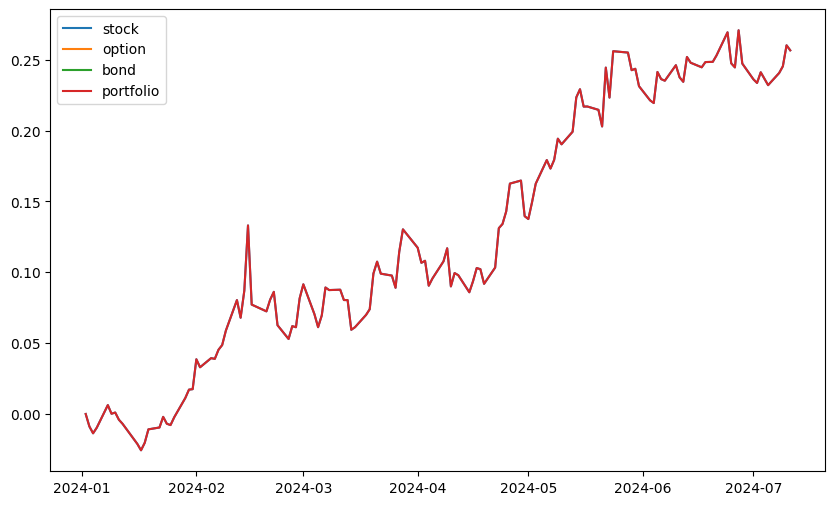

In [14]:
plt.figure(figsize=(10, 6))  
plt.plot(performance["date"].values,performance["stock_return"].values)
plt.plot(performance["date"].values,performance["option_return"].values)
plt.plot(performance["date"].values,performance["bond_return"].values)
plt.plot(performance["date"].values,performance["return"].values)
plt.legend(["stock","option","bond","portfolio"])

In [15]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [16]:
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

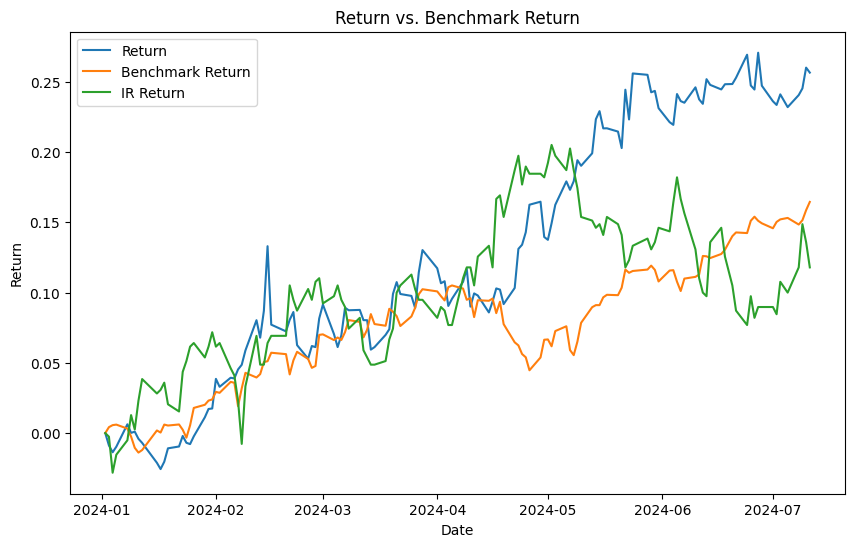

In [17]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [18]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

np.float64(1.0288111530684005)

In [19]:
visualization[["return","benchmark_return"]]

,return,benchmark_return
0,0.000000,0.000000
1,-0.008805,0.004232
2,-0.013642,0.005668
3,-0.009685,0.006040
4,0.006263,0.003197
...,...,...
127,0.232029,0.153164
128,0.240618,0.148455
129,0.245361,0.151528
130,0.260144,0.158662


In [28]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [29]:
t.sort_values("return",ascending=False).head(10)

,ticker,adjclose,quantity,excess_return,buy_price,buy_date,sell_date,pv,GICS Sector,return,hpr
125,SMCI,787.57,22.032914,0.039609,436.24,2024-01-22,2024-02-20,17352.461978,Information Technology,0.805359,29
323,GL,65.00,218.872393,0.043149,49.17,2024-04-11,2024-04-18,14226.705554,Financials,0.321944,7
396,VST,91.47,121.025639,0.046402,72.48,2024-04-25,2024-05-14,11070.215159,Utilities,0.262003,19
350,SMCI,857.44,24.565861,0.046321,717.02,2024-04-22,2024-04-26,21063.751950,Information Technology,0.195838,4
432,FSLR,251.75,107.869307,0.044512,212.11,2024-05-21,2024-05-22,27156.097971,Information Technology,0.186884,1
154,PANW,316.15,53.795828,0.042413,282.09,2024-02-23,2024-02-28,17007.550894,Information Technology,0.120742,5
228,PARA,12.51,744.259250,0.041007,11.20,2024-03-18,2024-03-20,9310.683219,Communication Services,0.116964,2
457,FSLR,276.78,105.484152,0.043849,249.81,2024-05-23,2024-05-30,29195.903606,Information Technology,0.107962,7
135,EQT,37.30,262.362196,0.041703,33.73,2024-02-20,2024-02-21,9786.109923,Energy,0.105840,1
42,KEY,14.20,690.754711,0.040406,13.20,2024-01-18,2024-01-22,9808.716898,Financials,0.075758,4


In [30]:
t.groupby(["GICS Sector"]).agg({"return":"mean","hpr":"mean"}).reset_index().sort_values("return")

,GICS Sector,return,hpr
8,Materials,-0.003187,3.031746
9,Real Estate,-0.002345,4.021739
5,Health Care,-0.002157,3.979167
1,Consumer Discretionary,-0.001126,2.893939
6,Industrials,-0.000912,3.760000
2,Consumer Staples,-0.000519,3.350877
0,Communication Services,0.002799,3.603774
3,Energy,0.002992,3.953488
10,Utilities,0.006964,4.547619
4,Financials,0.010823,3.220339


In [22]:
holdings = pd.DataFrame(sum([[x["stocks"][i] for x in states[-1]["positions"]] for i in range(number_of_stocks)],[]))
db.cloud_connect()
db.drop("trades")
db.drop("holdings")
db.drop("visualization")
db.store("visualization",visualization)
db.store("trades",t)
db.store("holdings",holdings)
db.disconnect() 